# 1. Regressão Logística com Regularização

Nesta parte do trabalho, será implementada a **_Regressão Logística Regularizada_**
para prever se os microchips de uma usina de fabricação passam na garantia
de qualidade (QA). Durante a QA, cada microchip passa por vários testes para
garantir se está funcionando corretamente. Dessa forma, a Gestão de Produto da 
fábrica terá o resultados de teste para alguns microchips em dois testes diferentes. 

A partir desses dois testes, será determinado se os microchips deveriam ser 
aceitos ou rejeitados. Para auxiliar a tomar a decisão, há um conjunto de dados
com resultados de testes anteriores sobre microchips, a partir do qual é possível construir
um modelo de Regressão Logística.

O arquivo {ex2data2.txt} contém os dados a serem usados nessa parte do trabalho. A primeira 
coluna corresponde aos resultados do primeiro teste, enquanto que a segunda coluna corresponde
aos resultados do segundo teste. A terceira coluna contém os valores da classe (y = 0 significa 
rejeitado no teste, e y = 1 significa aceito no teste).

## 1.1 Visualização dos Dados

Para a maioria dos conjuntos de dados do mundo real, não é possível criar um gráfico para 
visualizar seus pontos. Mas, para o conjunto de dados fornecido, isso é possível. Implemente 
um script em _Python_ que produza um gráfico de dispersão (scatter plot) dos dados fornecidos. 
Após finalizado, seu script deve produzir um resultado similar ao apresentado na Figura abaixo.

![ScatterPlot](scatter_plot2.jpg)


In [60]:
import os 
import pandas as pd
import numpy as np
import matplotlib as plt

%matplotlib inline

# Carregando o arquivo gerado pelo MATLAB
#import scipy.io
#mat = scipy.io.loadmat('file.mat')

In [61]:
# Construindo um dataset com base num Dataframe, já identificando colunas e exibindo seus primeiros 20 registros.
df = pd.read_csv('am-T2-dados/ex2data2.txt', names=['QATest1', 'QATest2', 'QAcceptance'])
df.head()

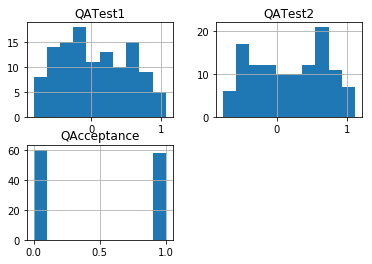

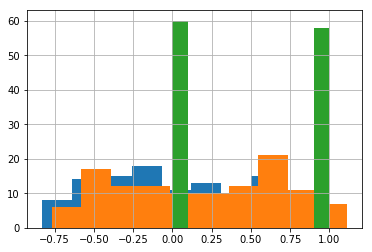

In [62]:
# Visualização da Distribuição dos Dados conforme Histograma

df.hist()
plt.pyplot.show()

df.QATest1.hist(), df.QATest2.hist(), df.QAcceptance.hist()
plt.pyplot.show()

In [59]:
df.QATest1.describe().round(2)

count    118.00
mean       0.05
std        0.50
min       -0.83
25%       -0.37
50%       -0.01
75%        0.48
max        1.07
Name: QATest1, dtype: float64

In [51]:
df.QATest2.describe().round(2)

count    118.00
mean       0.18
std        0.52
min       -0.77
25%       -0.25
50%        0.21
75%        0.65
max        1.11
Name: QATest2, dtype: float64

In [52]:
df.QAcceptance.describe().round(2)

count    118.00
mean       0.49
std        0.50
min        0.00
25%        0.00
50%        0.00
75%        1.00
max        1.00
Name: QAcceptance, dtype: float64

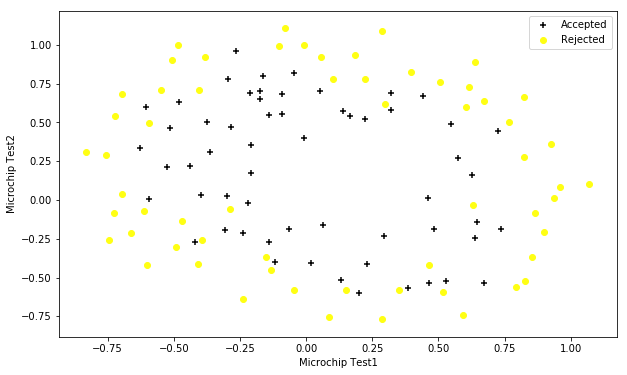

In [75]:
# Gráfico de correlação entre População e Lucro

positive = df[df['QAcceptance'].isin([1])]  
negative = df[df['QAcceptance'].isin([0])]

figura, grafico = plt.pyplot.subplots(figsize=(10,6))  
grafico.scatter(positive['QATest1'], positive['QATest2'], c='xkcd:black', marker='+', label='Accepted')  
grafico.scatter(negative['QATest1'], negative['QATest2'], c='xkcd:yellow', marker='o', label='Rejected')  
grafico.legend()  
grafico.set_xlabel('Microchip Test1')  
grafico.set_ylabel('Microchip Test2');

## 1.2 Mapeamento de características (_feature mapping_)

Uma maneira de tornar os dados mais apropriados para a classificação é criar
mais características a partir das já existentes. Para isso, você deve criar uma
função mapFeature. essas função deve ser implementada em um arquivo de
nome mapFeature.py, que irá mapear as características para todos os termos
polinomiais de x1 e x2, até a sexta potência.

Como resultado desse mapeamento, nosso vetor de duas características (os
escores em dois testes de QA) será transformado em um **vetor de _28 dimensões_**.
Um classificador que usa regressão logística treinado nesse vetor de características 
de maior dimensão terá uma fronteira de decisão mais complexa e parecerá não-linear 
quando desenhado em um gráfico bidimensional. Embora o mapeamento de características 
nos permita construir um classificador mais expressivo, também é mais suscetível a 
sobreajuste (overfitting). Nas próximas partes do exercício, você implementará a 
**_Regressão Logística Regularizada_** sobre os dados fornecidos e também verá 
como a regularização pode ajudar a combater o problema do sobreajuste.

In [66]:
def mapFeature(X) :
    '''
    Função de mapeamento das características
    '''
    
    degree = 5  
    x1 = df['Test 1']  
    x2 = df['Test 2']

    df.insert(3, 'Ones', 1)

    for i in range(1, degree):  
        for j in range(0, i):
            df['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

    df.drop('Test 1', axis=1, inplace=True)  
    df.drop('Test 2', axis=1, inplace=True)

    return df

In [70]:
degree = 5  
x1 = data2['Test 1']  
x2 = data2['Test 2']

data2.insert(3, 'Ones', 1)

for i in range(1, degree):  
    for j in range(0, i):
        df['X' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)

data2.drop('Test 1', axis=1, inplace=True)  
data2.drop('Test 2', axis=1, inplace=True)

data2.head()

,Accepted,Ones
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


## 1.3 Função de custo e gradiente

Agora, você deverá implementar o código para calcular **_a função de custo e
o gradiente para a regressão logística regularizada_**. Crie um arquivo de nome
costFunctionReg.py que contém uma função de nome costFunctionReg.py
e que computa o custo e o gradiente. Lembre-se de que a função de custo
regularizada na regressão logística é dada por:
    
    
Depois de concluir a implementação da função **costFunctionReg**, você deve
testar a corretude dela usando o valor inicial de ø (inicializado todo com zeros).
Você deve ver que o custo é de cerca de 0.693.
Porém, usando a função **costFunctionReg**, você agora deve computar os valores ótimos para ø.

In [72]:
def sigmoid(x):
    '''
    A função sigmoid
    '''
    #g = np.array([x]).flatten()
    s = 1 / (1 + np.exp(-g))
    return s

In [73]:
def costFunctionReg(theta, X, y, alpha): 
    '''
    A versão do GD que acabamos de estudar é denominada *Batch gradienteient Descent*.
    Em cada iteração do algoritmo, todo o conjunto de treinamento é utilizado.

        X = características (features)
        y = alvo (target)
        alpha = taxa de aprendizado
        REG = Taxa de regularização

    '''
    
    #theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    m = X.size
    
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    REG = (alpha / 2*m) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    
    J = (1/m) * np.sum(first - second) + REG

    parameters = int(theta.ravel().shape[1])
    gradiente = np.zeros(parameters)
    error = sigmoid(X * theta.T) - y

    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        if (i == 0):
            gradiente[i] = np.sum(term)/m
        else:
            gradiente[i] = np.sum(term)/m + ((alpha/m) * theta[:,i])


    return J, gradiente

### 1.3.1 Testando a Função de Custo e o Gradiente

In [74]:
# set X and y (remember from above that we moved the label to column 0)
#df.QATest1
#df.QATest2

cols = df.shape[1]  
X2 = df.iloc[:,2]  
y2 = df.iloc[:,:2]

# convert to numpy arrays and initalize the parameter array theta
X2 = np.array(X2.values)  
y2 = np.array(y2.values)  
theta2 = np.zeros(11)

learningRate = 0.01

costFunctionReg(theta2, X2, y2, learningRate) 

ValueError: shapes (1,118) and (1,11) not aligned: 118 (dim 1) != 1 (dim 0)

## 1.4 Esboço da fronteira de decisão

Nessa parte, voc^e deve esbocar (plotar) a fronteira de decis~ao que foi aprendida
para separar os exemplos positivos dos negativos. Crie uma arquivo de nome
plotDecisionBoundary.py, para criar esse graco que traca o limite da decis~ao
n~ao-linear. Seu graco deve ser semelhante ao apresentado na **_Figura_** abaixo.

![ScatterBoundaryPlot](scatter_boundary.jpg)

In [ ]:
def plotDecisionBoundary(X, y, theta, alpha, iteracao):
    '''
    A versão do GD que acabamos de estudar é denominada *Batch Gradient Descent*.
    Em cada iteração do algoritmo, todo o conjunto de treinamento é utilizado.

        X = características (features)
        y = alvo (target)
    '''
    m = y.size
    J = np.zeros(shape=(iteracao, 1))

    for i in range(iteracao):
        hipotese = X.dot(theta).flatten()
        errors_x1 = (hipotese - y) * X[:, 0]
        errors_x2 = (hipotese - y) * X[:, 1]

        theta[0][0] = theta[0][0] - alpha * (1.0 / m) * errors_x1.sum()
        theta[1][0] = theta[1][0] - alpha * (1.0 / m) * errors_x2.sum()
        J[i, 0] = computarCusto(X, y, theta)

    return theta, J

In [ ]:
X = df.Populacao
y = df.Lucro

# Número do conjunto de treinamento
m = y.size    

# Adicionando uma coluna de 1's ao novo X 
X_teste = np.ones(shape=(m, 2))
X_teste[:, 1] = X

# Inicializando os parâmetros theta
theta = np.zeros(shape=(2, 1))

# Configuração de valores para Gradiente Descendente
iteracao = 1500
taxa_aprendizado = 0.01

# Utilizando da função gradienteDescendente para obter os valores theta e J
theta, J = gradienteDescendente(X_teste, y, theta, taxa_aprendizado, iteracao)

# Efetuando uma predição de lucro para os valores de 35000 and 70000 da população
print('\t ######################  Casos de Predição de Lucro  ######################\n')
lucro35 = np.array([1, 35000]).dot(theta).flatten()
print('\t Para uma população de 35000 habitantes, prevemos um lucro de %f' % lucro35)

lucro70 = np.array([1, 70000]).dot(theta).flatten()
print('\t Para uma população de 70000 habitantes, prevemos um lucro de %f\n' % lucro70)
print('\t ##########################################################################\n')

In [ ]:
# Apresentando a linha de regressão no gráfico de Correlação
plt.scatter(df.Populacao, df.Lucro,  c= 'red', marker='x')
plt.title('Distribuição do Lucro e Previsão')
xlabel('População de 10000 habitantes')
ylabel('Lucro de US$10K')

result = X_teste.dot(theta).flatten()
plot(df.Populacao, result, 'b')
show()

## 1.3 Visualização de J(ø)

Para melhor entender a função de custo, você irá nessa parte do trabalho plotar o custo sobre 
uma grade bidimensional de valores de 0 e de 1. Para isso, você deve usar sua implementação da função **computarCusto**.

O código que você deve implementar deve gerar um array bidimensional de valores de J(ø). Os valores gerados pelo seu código devem estar na faixa a seguir: -10;0;+10 e -1;+4. Utilize incremento de 0.01 para gerar os valores de 0 e de 1.

A seguir, usando a função _matplotlib.pyplot.contour_ da biblioteca matplotlib, produza um gráfico de curvas de contorno (contour plot). Também
utilizando a biblioteca matplotlib, crie um gráfico da superfície correspondente a J(ø).

In [ ]:
# Adicionando uma coluna de 1's em X p/ X de teste
X_teste = np.ones(shape=(m, 2))
X_teste[:, 1] = X

# Construindo a superfície para representar J(ø)
theta0 = np.linspace(-10, 10, 100) # Intervalo para theta0 (-10;10)
theta1 = np.linspace(-1, 4, 100)   # Intervalo para theta1 (-1;4)

# Inicializando J(ø) com uma matriz de zeros
J = np.zeros(shape=(theta0.size, theta1.size))

# Preenchendo a matriz J
for t1, element1 in enumerate(theta0):
    for t2, element2 in enumerate(theta1):
        thetaT = np.zeros(shape=(2, 1))
        thetaT[0][0] = element1
        thetaT[1][0] = element2
        J[t1, t2] = computarCusto(X_teste, y, thetaT)

# Plotando a Superfície de Contorno correspondente a J(ø)
plt.contour(theta0, theta1, J.T, np.logspace(-4, 5, 50))
plt.title('Gráfico da Superfície J(ø)')
xlabel('Theta0')
ylabel('Theta1')
plt.scatter(theta[0][0], theta[1][0])
show()

# 2. Regressão Linear com Múltiplas Variáveis


Nessa parte do trabalho, você irá implementar a regressão linear com múltiplas variáveis para predizer 
o preço de venda de imóveis. O arquivo ex1data2.txt contém informações acerca de preços de imóveis. 
A primeira coluna corersponde ao tamanho do imóvel (em _pés quadrados_). A segunda coluna corresponde à
quantidade de dormitórios no imóvel em questão. A terceira coluna corresponde ao preço do imóvel.

## Visualização dos dados

In [ ]:
# Carregando o dataset na forma de txt, porque tem melhor desempenho p/ representação gráfica e 
# principalmente na vertorização, se comparado ao Dataframe, utilizado na primeira seção deste trabalho.

data = np.loadtxt('am-T1-dados/ex1data2.txt', delimiter=',')

In [ ]:
data

In [ ]:
# Inicializando visualização gráfica
plano = plt.figure()
plano = plano.add_subplot(111, projection='3d')

# Criação dos pontos ('x' vermelhos) para o gráfico
for c, m in [('red', 'x')]:
    tamanho = data[:, 0] 
    quartos = data[:, 1] 
    valor   = data[:, 2] 
    plano.scatter(tamanho, quartos, valor, c=c, marker=m)


# Plotando o Gráfico
plano.set_xlabel('Tamanho')
plano.set_ylabel('Nº de Quartos')
plano.set_zlabel('Valor do Imóvel')
show()

## 2.1 Normalização das características

Se você inspecionar os valores do conjunto de dados fornecido, irá notar que os tamanhos dos imóveis são 
aproximadamente 1000 vezes maiores que as quantidades encontradas na coluna de quantidade de dormitórios. 
Sua tarefa nessa parte é implementar uma função denominada normalizarCaracteristica em um arquivo denominado 
normalizarCaracteristica.py. Essa função deve:

 - subtrair o valor médio de todas as características do conjunto de dados.
 - após subtrair a média, dividir cada característica pelos seus respectivos desvios padrões.

A sua função **normalizarCaracteristica** deve a matriz de dados X de dados como parâmetro (na forma de um numpy array). Além disso, essa função deve funcionar com conjuntos de dados de variados tamanhos (qualquer quantidade
de características / exemplos). Repare que cada coluna da matriz de dados X passada para a função **normalizarCaracteristica** deve corresponder a um característica.

**Nota de Implementação**: Ao normalizar as características, é importante armazenar os valores utilizados para a normalização - o valor médio e o desvio padrão utilizados para a normalização. Depois de aprender os parâmetros do modelo, muitas vezes queremos prever os preços das casas que não temos visto antes. Dado um novo valor x (área da sala de estar e número de quartos), devemos normalizar x usando a média e o desvio padrão que nós previamente
calculamos a partir do conjunto de treinamento.

In [ ]:
def normalizarCaracteristica(X):
    '''
    Retorna uma versão normalizada de X onde o valor médio de cada característica é 0 
    e o desvio padrão é 1. Este é frequentemente um bom passo de pré-processamento 
    a ser feito ao trabalhar com algoritmos de aprendizado.
    '''
    valormedio = []
    desviopadrao = []
    X_Normalizado = X

    for i in range(X.shape[1]):
        m = np.mean(X[:, i])
        s = np.std(X[:, i])
        valormedio.append(m)
        desviopadrao.append(s)
        X_Normalizado[:, i] = (X_Normalizado[:, i] - m) / s

    return X_Normalizado, valormedio, desviopadrao

## 2.2 Gradiente descendente

Anteriormente, você implementou o GD em uma regressão linear univariada. A única diferença agora é que há mais uma característica na matriz de dados X. A função de hipótese h(x) e a atualização dos gradientes em lote permanecem inalteradas. Você deve implementar código nos arquivos denominados **computarCustoMulti.py** e **gdmulti.py** para implementar a função de custo e o algoritmo GD para regressão linear com múltiplas variáveis, respectivamente. Se o seu código na parte anterior (variável única) já provê suporte a múltiplas variáveis, você também pode reusá-lo aqui. Se assegure de que o seu código dá suporte a qualquer número de características e está bem vetorizado.

In [ ]:
def computarCustoMulti(X, y, theta):
    '''
    Função que computa o custo para Regressão Linear com múltiplas variáveis.
    '''
    # Número do conjunto de treinamento
    m = y.size
    J = (1 / (2 * m)) * (X.dot(theta) - y).T.dot(X.dot(theta) - y)
    return J

In [ ]:
def gradienteDescendenteMulti(X, y, theta, alpha, iteracoes):
    '''
    Essa função calcula o gradiente descendente conforme o Theta, e com
    etapas de iteracoes gradiente mediante a taxa de aprendizado em Alpha.
    '''
    m = y.size
    J = np.zeros(shape=(iteracoes, 1))

    for i in range(iteracoes):
        hipotese = X.dot(theta)
        
        for it in range(theta.size):
            temp = X[:, it]
            temp.shape = (m, 1)

            errors_x1 = (hipotese - y) * temp
            theta[it][0] = theta[it][0] - alpha * (1.0 / m) * errors_x1.sum()

        J[i, 0] = computarCustoMulti(X, y, theta)

    return J

In [ ]:
X = data[:, :2]
y = data[:, 2]

# Tamanho do conjunto de treinamento
m = y.size
y.shape = (m,1)

# Normalizando X, obtendo Média e Desvio-padrão
x, media, desviopadrao = normalizarCaracteristica(X)

# Adicionando uma coluna de 1's ao novo X
Xnovo = np.ones(shape=(m, 3))
Xnovo[:, 1:3] = x

# Atributos para a função GradienteDescendenteMulti
iteracao = 100           # Número de repeticões p/ o algoritmo
alpha = 0.01             # Taxa de aprendizado

# Inicializando o Theta p/ execução da função GradienteDescendenteMulti
theta = np.zeros(shape=(3, 1))
J = gradienteDescendenteMulti(Xnovo, y, theta, alpha, iteracao)

plot(np.arange(iteracao), J)
xlabel('Iteracões')
ylabel('Função de Custo')
show()

# 3. Regressão Logística

Nessa parte do trabalho, você irá implementar a regressão logística. Em particular,
você irá criar uma classificador para predizer se um estudante será admitido em uma 
universidade, com base nos resultados de duas avaliações. Suponha que estão disponíveis 
dados históricos acerca de realizações passadas dessas avaliações, e que esses dados 
históricos podem ser usados como conjunto de treinamento. Para cada exemplo desse conjunto 
de treinamento, temos as notas das duas avaliações e a decisão acerca do candidato 
(aprovado ou reprovado). 

Sua tarefa é construir um modelo de classificação que provê uma estimativa da probabilidade 
de admissão de um candidato, com base na notas que ele obteve nas duas avaliações. 

O arquivo **ex2data1.txt** contém os dados a serem usados nessa parte do trabalho.

## 3.1 Visualização dos dados

Antes de começar a implementar qualquer algoritmo de aprendizado, é adequado
visualizar os dados, quando possível. Nessa parte do trabalho, você deve
carregar o arquivo com o conjunto de treinamento e plotar (i.e., produzir um
gráfico) os pontos de dados. O resultado dessa tarefa deve ser um gráfico similar
ao apresentado na _Figura_ abaixo.

![Boundary.png](Boundary.png)


In [ ]:
# carregando os dados 
data = np.loadtxt('am-T1-dados/ex2data1.txt', delimiter=',', usecols=(0,1,2), unpack=True)

In [ ]:
# Transportando matriz
X = np.transpose(np.array(data[:2]))
y = np.transpose(np.array(data[2:]))

# Tamanho do conjunto de treinamento
m = y.size

# Adicionando uma coluna de 1's ao novo X
X = np.insert(X,0,1,axis=1)

# Classificando a amostra em Positiva (data[:, 2]=1) e Negativa(data[:, 2]=0)
X_Admitted  = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
X_Nadmitted = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])

plt.figure(figsize=(16,8))
plt.plot(X_Admitted[:, 1], X_Admitted[:, 2],'k+',label='Admitted')
plt.plot(X_Nadmitted[:, 1], X_Nadmitted[:, 2],'yo',label='Not admitted')
plt.title('Gráfico Decision Boundary p/ admissão de candidato', fontsize=18, fontweight='bold')
plt.xlabel('Exam 1 Score', fontweight='bold')
plt.ylabel('Exam 2 Score', fontweight='bold')
plt.legend()
plt.grid(False)    
plt.show()

## 3.2 Implementação

### 3.2.1 Função sigmoide

Como primeiro passo nessa parte, implemente a função em Python que calcula
o valor da função **sigmoide**. Defina essa função em um arquivo denominado
**_sigmoide.py_**, de tal forma que ela possa ser chamada de outras parte do seu
código. Após finalizar sua implementação, você pode verificar sua corretude:

 - Para a sigmoide(0), o valor retornado deve ser 0.5. 
 - Para valores muito grandes positivos (ou negativos), ela retornará um valor muito próximo de 1 (ou de 0). 

O seu código também deve funcionar com vetores (i.e., **o seu código deve estar vetorizado**). Em particular, se
uma matriz for passada, o seu código deve aplicar a função sigmoide a cada componente.

In [ ]:
def sigmoid(x):
    '''
    A função sigmoid
    '''
    g = np.array([x]).flatten()
    s = 1 / (1 + np.exp(-g))
    return s

In [ ]:
print('\t ###########################  Teste para função sigmoid(0)  ###########################\n')
print('\t O Valor da Sigmoid(0) é', sigmoid(0))
print('\t O Valor da Sigmoid([0,1,2,3000]) é', sigmoid(np.array([0,1,2,3000])))
print('\t ######################################################################################\n')

In [ ]:
# Exibindo o gráfico da função Sigmoid
X_teste = np.arange(-6,6,.5)
plt.plot(X_teste, sigmoid(X_teste))
plt.title("Função Sigmoid", fontsize=18, fontweight='bold')
plt.grid(True)
plt.show()

## 3.2.2 Função de custo e gradiente

Agora, você deverá implementar a função de custo para a regressão logística.
Essa função deve retornar o valor de função de custo e o gradiente. Implemente
esse código em um arquivo denominado funcaoCustoRegressaoLogistica.py.
Lembre-se de que o gradiente é um vetor com o mesmo número de elementos que ø.

Uma vez que tenha implementado essa função, realize uma chamada usando
o valor inicial de ø. Você deve confirmar que o valor produzido é aproximadamente 0.693.

In [ ]:
def custoJ(theta, X, y):
    '''
    A função custoJ retorna o valor de função de custo:
        X é uma matrix com n-colunas e m-linhas
        y é um vetor com m-linhas
        theta é um vetor n-dimensional
        
    Obs.: Será utilizada para facilitar o cálculo de minimização. 
    '''
    m = len(y)
    H = sigmoid(X.dot(theta).T)
    J = -np.sum( y* np.log(H) + (1-y) * np.log(1-H))/m
    return J

In [ ]:
def custoRegressaoLogistica(theta, X, y):
    '''
    A função funcaoCustoRegressaoLogistica retorna o valor de função de custo e o gradiente.
        Returna J, gradiente:
        
        X é uma matrix com n-colunas e m-linhas
        y é um vetor com m-linhas
        theta é um vetor n-dimensional
    '''
    
    # Calcula o Custo
    m = len(y)
    H = sigmoid(X.dot(theta).T)
    J = -np.sum( y* np.log(H) + (1-y) * np.log(1-H))/m

    # Calcula o Gradiente
    erro = H-y
    gradiente = []
    for i in range(len(X.columns)):
        gradiente.append(np.sum(erro*(X.iloc[:,i]))/m)
    
    return J, gradiente

## 3.2.3 Aprendizado dos parâmetros

Para a regressão logística, o objetivo é minimizar J(ø) com relação ao vetor
de parâmetros ø. Sendo assim, nessa parte você deve implementar uma função
em Python para encontrar o vetor ø que minimiza a função de custo. Utilize a
função **funcaoCustoRegressaoLogistica** que você implementou previamente.

In [ ]:
from scipy import optimize

def minimizar(theta, X, y):
    '''
    A função minimizar J(ø) com relação ao vetor de parâmetros ø
    '''
    minimo = optimize.fmin(func=custoJ, x0=theta, args=(X, y), maxiter=1000, full_output=True)
    return minimo[0], minimo[1]

In [ ]:
# Utilizando uma segunda estrutura de dados
df = pd.read_csv('am-T1-dados/ex2data1.txt', names=['Exame1', 'Exame2', 'Admissao'])

X = df.iloc[:, :2]
y = df.iloc[:, 2]
X.head()

In [ ]:
#add a column of ones to the feature matrix X to account for theta 0
m = len(y)
X.insert(0, "theta0",value=pd.Series(np.ones([m])))
X.head()

In [ ]:
# Apresentando uma visualização gráfica com base na classificação
from seaborn import lmplot

g = lmplot("Exame1", "Exame2", hue="Admissao", data=df, fit_reg=True, palette = "dark", markers = ["o","x"], legend = True)
plt.xlabel("Exame 1 Score")
plt.ylabel("Exame 2 Score")
plot_x = np.array([min(X.iloc[:,2])-2,  max(X.iloc[:,2])+2])
plt.ylim(30,100)

In [ ]:
theta0 = np.zeros([X.shape[1], 1])
hypothesis = sigmoid(X.dot(theta0).T)
print(hypothesis)

In [ ]:
print(custoRegressaoLogistica(theta0, X, y))

In [ ]:
# 
print(custoJ(theta0, X, y))

In [ ]:
# Avaliando a minimização
X_min, theta_min = minimizar(theta0, X, y)
print(X_min, theta_min)

## 3.2.4 Avaliação do modelo

Após o aprendizado dos parâmetros, você pode usar o modelo correspondente
para predizer se um candidato qualquer será aprovado. Para um candidato
com **_notas 45 e 85 na primeira e segunda avaliações_**, respectivamente, você deve
esperar que ele seja aprovado com **probabilidade de 77.6%**.

Outro modo de avaliar a qualidade dos parâmetros é verificar o quão bem o
modelo aprendido prediz os pontos de dados do conjunto de treinamento. Nessa
parte, você deve implementar uma função denominada predizer. Essa função
deve produzir os valores 0 ou 1, dados um exemplo do conjunto de treinamento
o vetor de parâmetros ø. Use essa função para produzir a porcentagem de
acertos do seu classificador sobre o conjunto de treinamento.

In [ ]:
def predizer(theta, X):
    P = sigmoid(X.dot(theta))
    return (P >= 0.5).astype(int)

In [ ]:
# Predição de Admissão do candidato
A = np.array([1,45,85])
H = sigmoid(A.dot(X_min))

# Efetuando predição p/ Admissão de um candidato com notas 45 e 85 na primeira e segunda avaliações 
print('\t ######################################  ALUNO TESTE  #################################\n')
print('\t Para as notas 45 e 85 no 1º e 2º Exame prevê a probabilidade de admissão de %f' % H)
print('\t ######################################################################################\n')